In [52]:
import string
import datetime
import email
import re
from tqdm import tqdm
import logging

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer




In [20]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [21]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1.  Data Preparation

In [22]:
# Read the CSV File
raw_emails_df = pd.read_csv('giskard_dataset.csv', sep=';')


In [23]:
raw_emails_df

,Unnamed: 0,Target,Message
0,0,internal company policy,Message-ID: <32715630.1075840547840.JavaMail.e...
1,1,alliances / partnerships,Message-ID: <8721012.1075863428380.JavaMail.ev...
2,2,internal company operations,Message-ID: <8687721.1075852656109.JavaMail.ev...
3,3,internal company operations,Message-ID: <16562450.1075846168630.JavaMail.e...
4,4,internal projects -- progress and strategy,Message-ID: <955111.1075858690252.JavaMail.eva...
...,...,...,...
874,1616,internal company operations,Message-ID: <18983060.1075847582386.JavaMail.e...
875,1637,alliances / partnerships,Message-ID: <29879754.1075863427653.JavaMail.e...
876,1646,talking points,Message-ID: <3001077.1075863428054.JavaMail.ev...
877,1670,internal projects -- progress and strategy,Message-ID: <13669071.1075863428696.JavaMail.e...


### We see that the message column has all the email content (to, from, body, subject ). Let us extract the details from the mail. I explored two approches 

### Approch I

In [ ]:

def parse_raw_message(raw_message, target):
    '''
    To parse the raw emails 
    '''
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['message-id', 'date', 'from', 'to', 'subject', 'mime-version',
                       'x-from', 'x-to', 'x-folder', 'x-origin']
    for line in lines:
        email['target'] = target
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            
            if key == 'date':
                datetime_obj = line.split(':', 1)[1] # To split the first occurance
                #datetime_obj = datetime_obj.split(',')[1]
                datetime_obj = datetime_obj.split('(')[0]
                val = datetime_obj.strip()
                # datetime_obj = datetime.datetime.strptime(datetime_obj, 
                #                   '%a, %d %b %Y %H:%M:%S %z')
                # email['date'] = datetime_obj.date()
                # email['time'] = datetime_obj.time()
            else:
                val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email
def parse_into_emails(messages, targets):
    '''
    To save the parsed mails with targets 
    '''
    emails = [parse_raw_message(message, target) for message, target in zip(messages, targets)]
    return emails

email_df = pd.DataFrame(parse_into_emails(raw_emails_df.Message, raw_emails_df.Target))

### Approach II

In [24]:
def get_text_from_email(msg):
    '''
    To get the content from email objects
    '''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

In [25]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, raw_emails_df['Message']))
raw_emails_df.drop('Message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    raw_emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
raw_emails_df['Content'] = list(map(get_text_from_email, messages))

### I am proceeding with approch II since it is more flexible to fetch data with email library

In [17]:
raw_emails_df

,Unnamed: 0,Target,Message-ID,Date,From,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Content
0,0,internal company policy,<32715630.1075840547840.JavaMail.evans@thyme>,"Wed, 11 Jul 2001 08:29:27 -0700 (PDT)",legalonline-compliance@enron.com,Confidential Information and Securities Trading,1.0,text/plain; charset=us-ascii,7bit,Office of the Chairman - Enron Wholesale Servi...,"GILBERT-SMITH@mailman.enron.com, Gilbert-smith...",,,"|ExMerge - Gilbert-smith, Doug|need to read",GILBERTSMITH-D,doug gilbert smith 6-25-02.PST,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-..."
1,1,alliances / partnerships,<8721012.1075863428380.JavaMail.evans@thyme>,"Tue, 26 Jun 2001 09:40:17 -0700 (PDT)",j.kaminski@enron.com,"FW: Venezuela FX and inflation forecasts, June...",1.0,text/plain; charset=us-ascii,7bit,"Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...",'vkaminski@aol.com',,,"|VKAMINS (Non-Privileged)|Kaminski, Vince J|Se...",Kaminski-V,VKAMINS (Non-Privileged).pst,\n\n -----Original Message-----\nFrom: \tKoepk...
2,2,internal company operations,<8687721.1075852656109.JavaMail.evans@thyme>,"Wed, 13 Jun 2001 06:05:07 -0700 (PDT)",steven.kean@enron.com,Enron Expatriates in India,1.0,text/plain; charset=us-ascii,7bit,"Kean, Steven </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Lay, Kenneth </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...",,,|JSKILLIN (Non-Privileged)|Deleted Items,Skilling-J,JSKILLIN (Non-Privileged).pst,"John Brindle, David Cromley and others in the ..."
3,3,internal company operations,<16562450.1075846168630.JavaMail.evans@thyme>,"Mon, 21 Aug 2000 00:30:00 -0700 (PDT)",steven.kean@enron.com,Re: PLEASE READ & RESPOND,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,Steven J Kean,Michael Terraso,,,|Steven_Kean_Dec2000_1|Notes Folders|All docum...,KEAN-S,skean.nsf,Yes. Contact either Gia or John and get the b...
4,4,internal projects -- progress and strategy,<955111.1075858690252.JavaMail.evans@thyme>,"Sat, 16 Jun 2001 17:36:06 -0700 (PDT)",b..sanders@enron.com,FW: ISO's Response to BPA Rebuttal of Sheffrin...,1.0,text/plain; charset=us-ascii,7bit,"Sanders, Richard B. </O=ENRON/OU=NA/CN=RECIPIE...","'sbishop@gibbs-bruns.com', 'jalexander@gibbs-b...",,,"|Sanders, Richard B (Non-Privileged)|Sanders, ...",Sanders-R,"Sanders, Richard B (Non-Privileged).pst",\nThis is something interesting to put in your...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,1616,internal company operations,<18983060.1075847582386.JavaMail.evans@thyme>,"Sun, 13 May 2001 12:37:00 -0700 (PDT)",steven.kean@enron.com,Message from Clark C. Smith,1.0,text/plain; charset=us-ascii,7bit,Steven J Kean,Maureen McVicker,,,|Steven_Kean_June2001_1|Notes Folders|All docu...,KEAN-S,skean.nsf,include on the distribution list and send out ...
875,1637,alliances / partnerships,<29879754.1075863427653.JavaMail.evans@thyme>,"Mon, 25 Jun 2001 11:33:50 -0700 (PDT)",j.kaminski@enron.com,RE:,1.0,text/plain; charset=us-ascii,7bit,"Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...","'""Aruna Inalsingh@Reval"" <Aruna_Inalsingh@Reva...","Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...",,"|VKAMINS (Non-Privileged)|Kaminski, Vince J|Se...",Kaminski-V,VKAMINS (Non-Privileged).pst,"Aruna,\n\nI shall be in London this week. Plea..."
876,1646,talking points,<3001077.1075863428054.JavaMail.evans@thyme>,"Tue, 26 Jun 2001 08:58:12 -0700 (PDT)",j.kaminski@enron.com,RE: Marketing Plan & Meetings,1.0,text/plain; charset=us-ascii,7bit,"Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...","Kohli, Sandeep </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,"|VKAMINS (Non-Privileged)|Kaminski, Vince J|Se...",Kaminski-V,VKAMINS (Non-Privileged).pst,"Sandeep,\n\nThis looks great. I would talk to ..."
877,1670,internal projects -- progress and strategy,<13669071.1075863428696.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 03:14:41 -0700 (PDT)",j.kaminski@enron.com,RE: Test Message,1.0,text/plain; charset=us-ascii,7bit,"Kaminski, Vince J </O=

### X- folder, Subject , Content , Target and date seems interesting . Values of other columns either dont contribute to the common goal or  are already available in the Content which might lead to duplicacy 

In [26]:
emails_df = raw_emails_df[['X-Folder','Subject','Content', 'Date','Target']]


In [27]:
emails_df = emails_df.rename(columns={'X-Folder': 'Folder'})

In [28]:
emails_df

,Folder,Subject,Content,Date,Target
0,"\ExMerge - Gilbert-smith, Doug\need to read",Confidential Information and Securities Trading,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-...","Wed, 11 Jul 2001 08:29:27 -0700 (PDT)",internal company policy
1,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...","FW: Venezuela FX and inflation forecasts, June...",\n\n -----Original Message-----\nFrom: \tKoepk...,"Tue, 26 Jun 2001 09:40:17 -0700 (PDT)",alliances / partnerships
2,\JSKILLIN (Non-Privileged)\Deleted Items,Enron Expatriates in India,"John Brindle, David Cromley and others in the ...","Wed, 13 Jun 2001 06:05:07 -0700 (PDT)",internal company operations
3,\Steven_Kean_Dec2000_1\Notes Folders\All docum...,Re: PLEASE READ & RESPOND,Yes. Contact either Gia or John and get the b...,"Mon, 21 Aug 2000 00:30:00 -0700 (PDT)",internal company operations
4,"\Sanders, Richard B (Non-Privileged)\Sanders, ...",FW: ISO's Response to BPA Rebuttal of Sheffrin...,\nThis is something interesting to put in your...,"Sat, 16 Jun 2001 17:36:06 -0700 (PDT)",internal projects -- progress and strategy
...,...,...,...,...,...
874,\Steven_Kean_June2001_1\Notes Folders\All docu...,Message from Clark C. Smith,include on the distribution list and send out ...,"Sun, 13 May 2001 12:37:00 -0700 (PDT)",internal company operations
875,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE:,"Aruna,\n\nI shall be in London this week. Plea...","Mon, 25 Jun 2001 11:33:50 -0700 (PDT)",alliances / partnerships
876,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE: Marketing Plan & Meetings,"Sandeep,\n\nThis looks great. I would talk to ...","Tue, 26 Jun 2001 08:58:12 -0700 (PDT)",talking points
877,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE: Test Message,"Mike,\n\nThanks for your message. The meeting ...","Wed, 27 Jun 2001 03:14:41 -0700 (PDT)",internal projects -- progress and strategy


In [12]:
emails_df.isna().sum()

Folder     0
Subject    0
Content    0
Date       0
Target     0
dtype: int64

In [13]:
emails_df.isnull().sum()

Folder     0
Subject    0
Content    0
Date       0
Target     0
dtype: int64

## 2. Data Cleaning

In [29]:
# To Confirm there are no blank data 
emails_df = emails_df.drop(emails_df.query('Date == "" | Subject == "" | Content == "" | Folder ==""').index)
emails_df.reset_index(drop=True, inplace=True) # To reset the index of the dropped rows


In [30]:
def get_day_part(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [12]:
# Let us keep the emails_df untouched and create a copy for futher exploration. 
emails_refined_df = emails_df.copy()

In [31]:
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True, utc=True)
emails_df['day_part'] = emails_df.Date.dt.day_name() + " " +  emails_df.Date.dt.hour.apply(get_day_part) + " " + emails_df.Date.dt.month_name()


In [32]:
emails_df['Folder'] = emails_df['Folder'].apply(lambda x : x.split('\\')[1])

In [33]:
emails_df['Text'] = emails_df['day_part']  + " " + emails_df['Folder'] + " " + emails_df['Subject'] + " " + emails_df['Content']


In [42]:
emails_df

,Folder,Subject,Content,Date,Target,day_part,Text
0,"ExMerge - Gilbert-smith, Doug",Confidential Information and Securities Trading,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-...",2001-07-11 15:29:27+00:00,internal company policy,Wednesday Noon July,wednesday noon july exmerge gilbert smith doug...
1,VKAMINS (Non-Privileged),"FW: Venezuela FX and inflation forecasts, June...",\n\n -----Original Message-----\nFrom: \tKoepk...,2001-06-26 16:40:17+00:00,alliances / partnerships,Tuesday Noon June,tuesday noon june vkamins non privileged fw ve...
2,JSKILLIN (Non-Privileged),Enron Expatriates in India,"John Brindle, David Cromley and others in the ...",2001-06-13 13:05:07+00:00,internal company operations,Wednesday Noon June,wednesday noon june jskillin non privileged en...
3,Steven_Kean_Dec2000_1,Re: PLEASE READ & RESPOND,Yes. Contact either Gia or John and get the b...,2000-08-21 07:30:00+00:00,internal company operations,Monday Early Morning August,monday early morning august steven kean dec200...
4,"Sanders, Richard B (Non-Privileged)",FW: ISO's Response to BPA Rebuttal of Sheffrin...,\nThis is something interesting to put in your...,2001-06-17 00:36:06+00:00,internal projects -- progress and strategy,Sunday Late Night June,sunday late night june sander richard b non pr...
...,...,...,...,...,...,...,...
846,Steven_Kean_June2001_1,Message from Clark C. Smith,include on the distribution list and send out ...,2001-05-13 19:37:00+00:00,internal company operations,Sunday Evening May,sunday evening may steven kean june2001 1 mess...
847,VKAMINS (Non-Privileged),RE:,"Aruna,\n\nI shall be in London this week. Plea...",2001-06-25 18:33:50+00:00,alliances / partnerships,Monday Evening June,monday evening june vkamins non privileged aru...
848,VKAMINS (Non-Privileged),RE: Marketing Plan & Meetings,"Sandeep,\n\nThis looks great. I would talk to ...",2001-06-26 15:58:12+00:00,talking points,Tuesday Noon June,tuesday noon june vkamins non privileged marke...
849,VKAMINS (Non-Privileged),RE: Test Message,"Mike,\n\nThanks for your message. The meeting ...",2001-06-27 10:14:41+00:00,internal projects -- progress and strategy,Wednesday Morning June,wednesday morning june vkamins non privileged ...


### A Little inspection into the data lets us understand that some words like "hou", "ect", "ees", "cc", "na", "th" has been used which belong to the mail recipient .  "pm" is from the dateline . It doesnt help us in providing a meaning to the data . So I added them in stopwords 

In [37]:
def clean_data(columns, clean = None):
    """
    To Clean Data from columns of dataframes
    Removes unnecessary character, lowercases words 
    and performs stemming/lemitizing
    """
    data = re.sub(r"=[\s]{1}", "", columns) # To remove unwanted charater with patter "=" + number
    data = re.sub(r"=[\d]{1,4}", "", data) # To remove unwanted charater with patter "=" + number
    data = re.sub(r"&", "", data) # To remove =
    data = re.sub(r"\S*https?:\S*", "", data) # To remove URL
    data = re.sub(r"\S*.com\S*", "", data) # To remove websites
    data = re.sub(r"[^a-zA-Z0-9]", " ", data)
    data = re.sub(r'\s+', ' ', data).strip()
    data = data.lower() 
    data = nltk.word_tokenize(data)
    stopwords = nltk.corpus.stopwords.words('english')
    newstopwords = ['ect', 'hou', 'com', 'recipient', 'cc', 'na', 'ees', 'th', 'pm', 'folder', 'folders', 'pst'] 
    stopwords.extend(newstopwords)
    
    if clean == 'stem':
        ps = PorterStemmer() 
        data = [ps.stem(word) for word in data if not word in (stopwords)] # stemming all words that are not stopwords 
    elif clean == 'lem':
        lm = WordNetLemmatizer() # initialize lemmatizing 
        data = [lm.lemmatize(word) for word in data if not word in (stopwords)] # lemmitizing all words that are not stopwords 

    else:
        data = [word for word in data if not word in (stopwords)] # stemming all words that are not stopwords 
                                          

    data = ' '.join(data)
        
    return data

In [38]:
emails_df['Text'] = emails_df.apply(lambda x: clean_data(x['Text'], 'lem'), axis=1)


### Lets try to visualize the top words

In [39]:
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize_text(text, option):
  '''
  Tokenize the input text as per specified option
    1: Use python split() function
    2: Use regex to extract alphabets plus 's and 't
    3: Use NLTK word_tokenize()
    4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
  '''
  if option == 1:
    return text.split()
  elif option == 2:
    return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
  elif option == 3:
    return [word for word in word_tokenize(text) if (word.isalpha()==1)]
  elif option == 4:
    words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized
  else:
    logger.warn("Please specify option value between 1 and 4")
    return []

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in tqdm(messages, desc="Tokenizaing"):
        tokens = tokenize_text(message, 3) # Use option 3
        corpus.extend(tokens)
    logger.info("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    logger.info("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    logger.info("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(['ect', 'hou', 'com', 'recipient', 'cc', 'na', 'ees', 'th', 'pm', 'pg'])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:40]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(16,8))
        sns.barplot(x=y, y=x)
        plt.show()

    return vocab



Tokenizaing: 100%|██████████| 851/851 [00:12<00:00, 68.35it/s]
INFO:__main__:The number of all words: 869786
INFO:__main__:The number of unique words: 20568
INFO:__main__:Top 40 frequent words: ['power', 'said', 'state', 'california', 'enron', 'energy', 'price', 'utility', 'electricity', 'would', 'market', 'plant', 'gas', 'davis', 'year', 'time', 'new', 'could', 'billion', 'pge', 'may', 'cost', 'million', 'edison', 'one', 'rate', 'say', 'generator', 'blackout', 'bill', 'plan', 'also', 'customer', 'week', 'contract', 'san', 'last', 'federal', 'business', 'ferc']


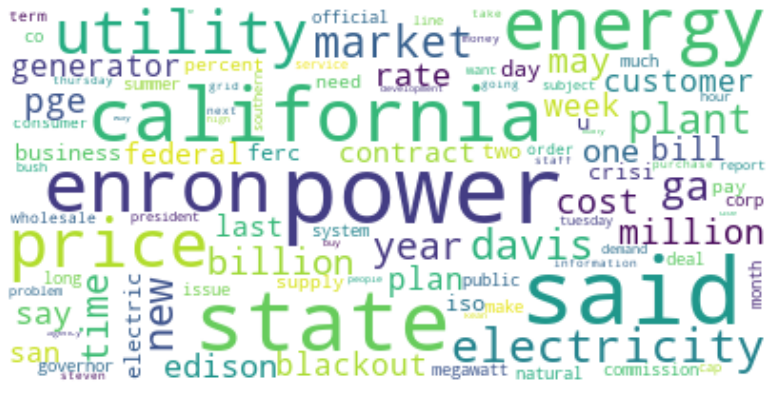

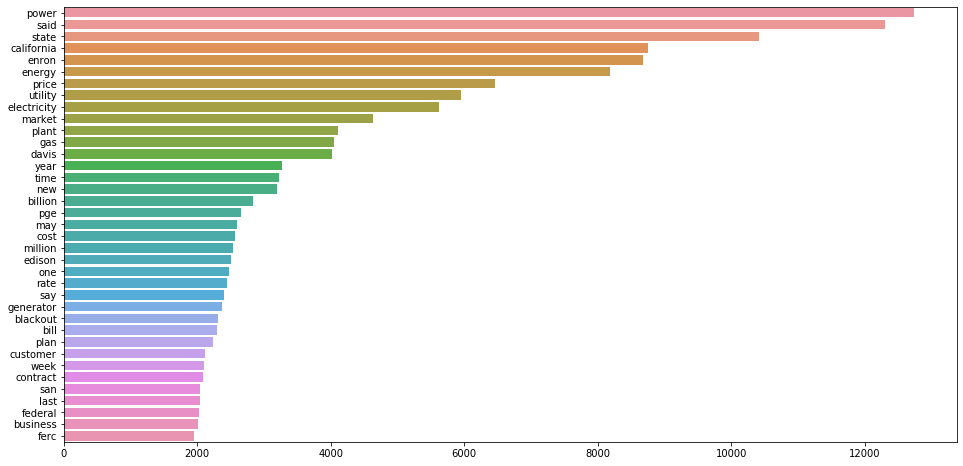

In [41]:
vocab= create_vocab(emails_df['Text'], True)


In [43]:
le = preprocessing.LabelEncoder()
emails_df['Target'] = le.fit_transform(emails_df.Target)
print(le.classes_)

[' company image -- current' 'alliances / partnerships'
 'california energy crisis / california politics'
 'company image -- changing / influencing' 'internal company operations'
 'internal company policy' 'internal projects -- progress and strategy'
 'legal advice' 'meeting minutes'
 'political influence / contributions / contacts'
 'regulations and regulators (includes price caps)' 'talking points'
 'trip reports']


## 3. Feature Engineering

### The Date column looks interesting, lets see if we can engineer the columns to get insights from the time at which the mail was sent

In [44]:
emails_df['Year'] = emails_df.Date.dt.year
emails_df['Month'] = emails_df.Date.dt.month
emails_df['Day'] = emails_df.Date.dt.day
emails_df['Hour'] = emails_df.Date.dt.hour


### OBSERVATION : Oldest mail available is from year 1980 and the latest mail is from year 2002

## 4. Exploratory Data Analysis

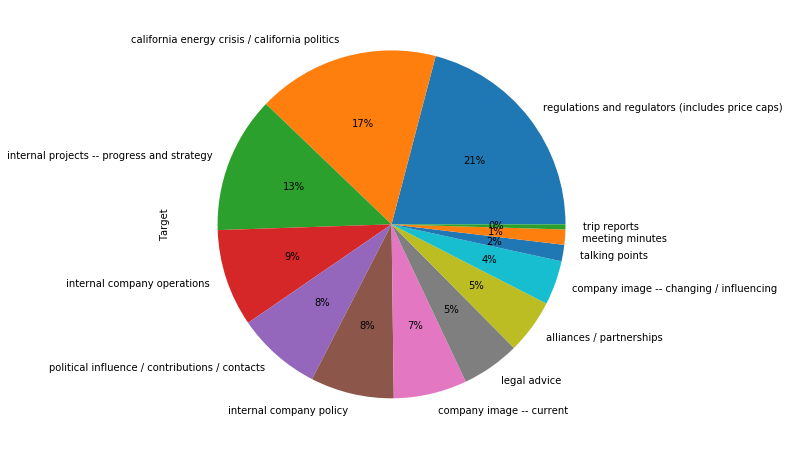

In [55]:
# Lets check the distribution of data for target 
plt.figure(figsize=(16,8))
emails_df.Target.value_counts().plot(kind='pie', autopct='%1.0f%%')

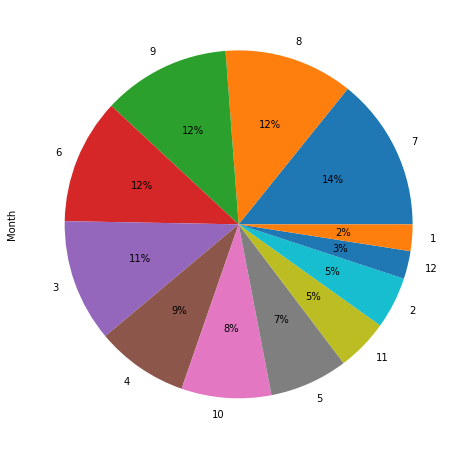

In [56]:
# Lets check the distribution of data for Months 
plt.figure(figsize=(16,8))
emails_df.Month.value_counts().plot(kind='pie', autopct='%1.0f%%')

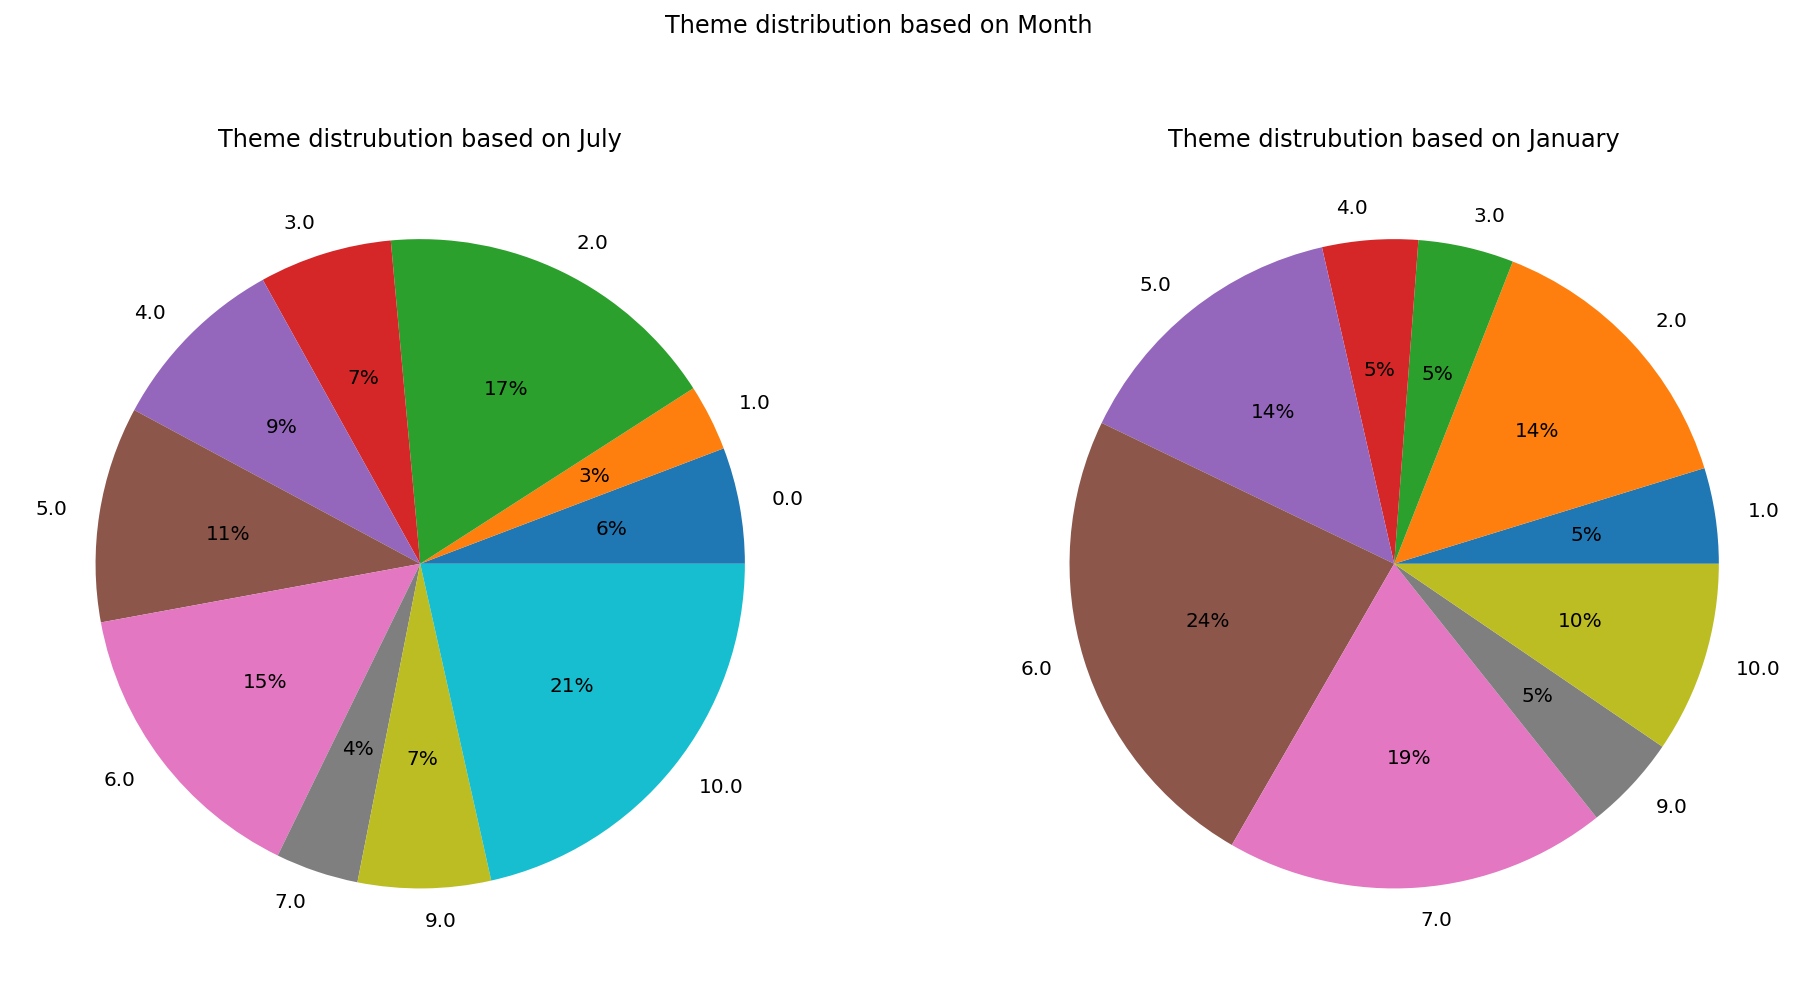

In [45]:
# Checking again after normalizing the values 
fig = plt.figure(figsize=(16,8),dpi=144)
ax1 = fig.add_subplot(121)
plt.suptitle("Theme distribution based on Month")
count = emails_df.where(emails_df["Month"]==7).Target.value_counts().to_frame().sort_index()
ax1.pie(count.Target, labels=count.index, autopct='%1.0f%%')
ax1.set_title("Theme distrubution based on July")
ax2 = fig.add_subplot(122)
count = emails_df.where(emails_df["Month"]==1).Target.value_counts().to_frame().sort_index()
ax2.pie(count.Target, labels=count.index, autopct='%1.0f%%')
ax2.set_title("Theme distrubution based on January")

plt.show()

In [180]:
print(le.classes_)

[' company image -- current' 'alliances / partnerships'
 'california energy crisis / california politics'
 'company image -- changing / influencing' 'internal company operations'
 'internal company policy' 'internal projects -- progress and strategy'
 'legal advice' 'meeting minutes'
 'political influence / contributions / contacts'
 'regulations and regulators (includes price caps)' 'talking points'
 'trip reports']


### OBSERVATION : We see that the data is not equally distributed . We are to explore sampling techniques in sometime

### OBSERVATION : Maximum mails have been sent in the month of july and least in January 

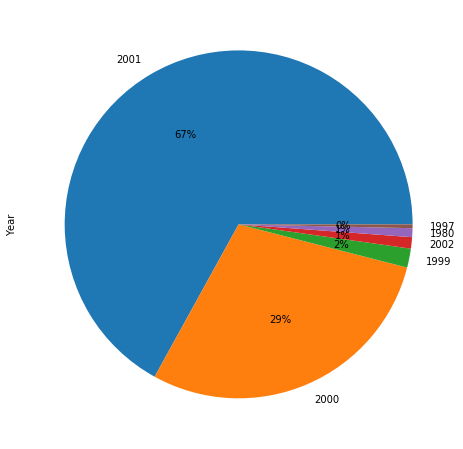

In [57]:
# Lets check the distribution of data for Year 
plt.figure(figsize=(16,8))
emails_df.Year.value_counts().plot(kind='pie', autopct='%1.0f%%')

### OBSERVATION : Maximum mails in the year 2001 and least in 1997

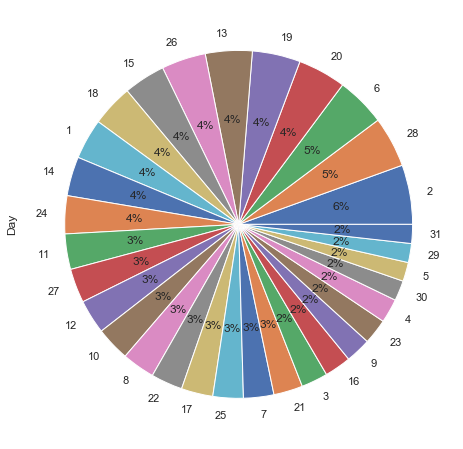

In [182]:
# Lets check the distribution of data for days of Month 
plt.figure(figsize=(16,8))
emails_df.Day.value_counts().plot(kind='pie', autopct='%1.0f%%')

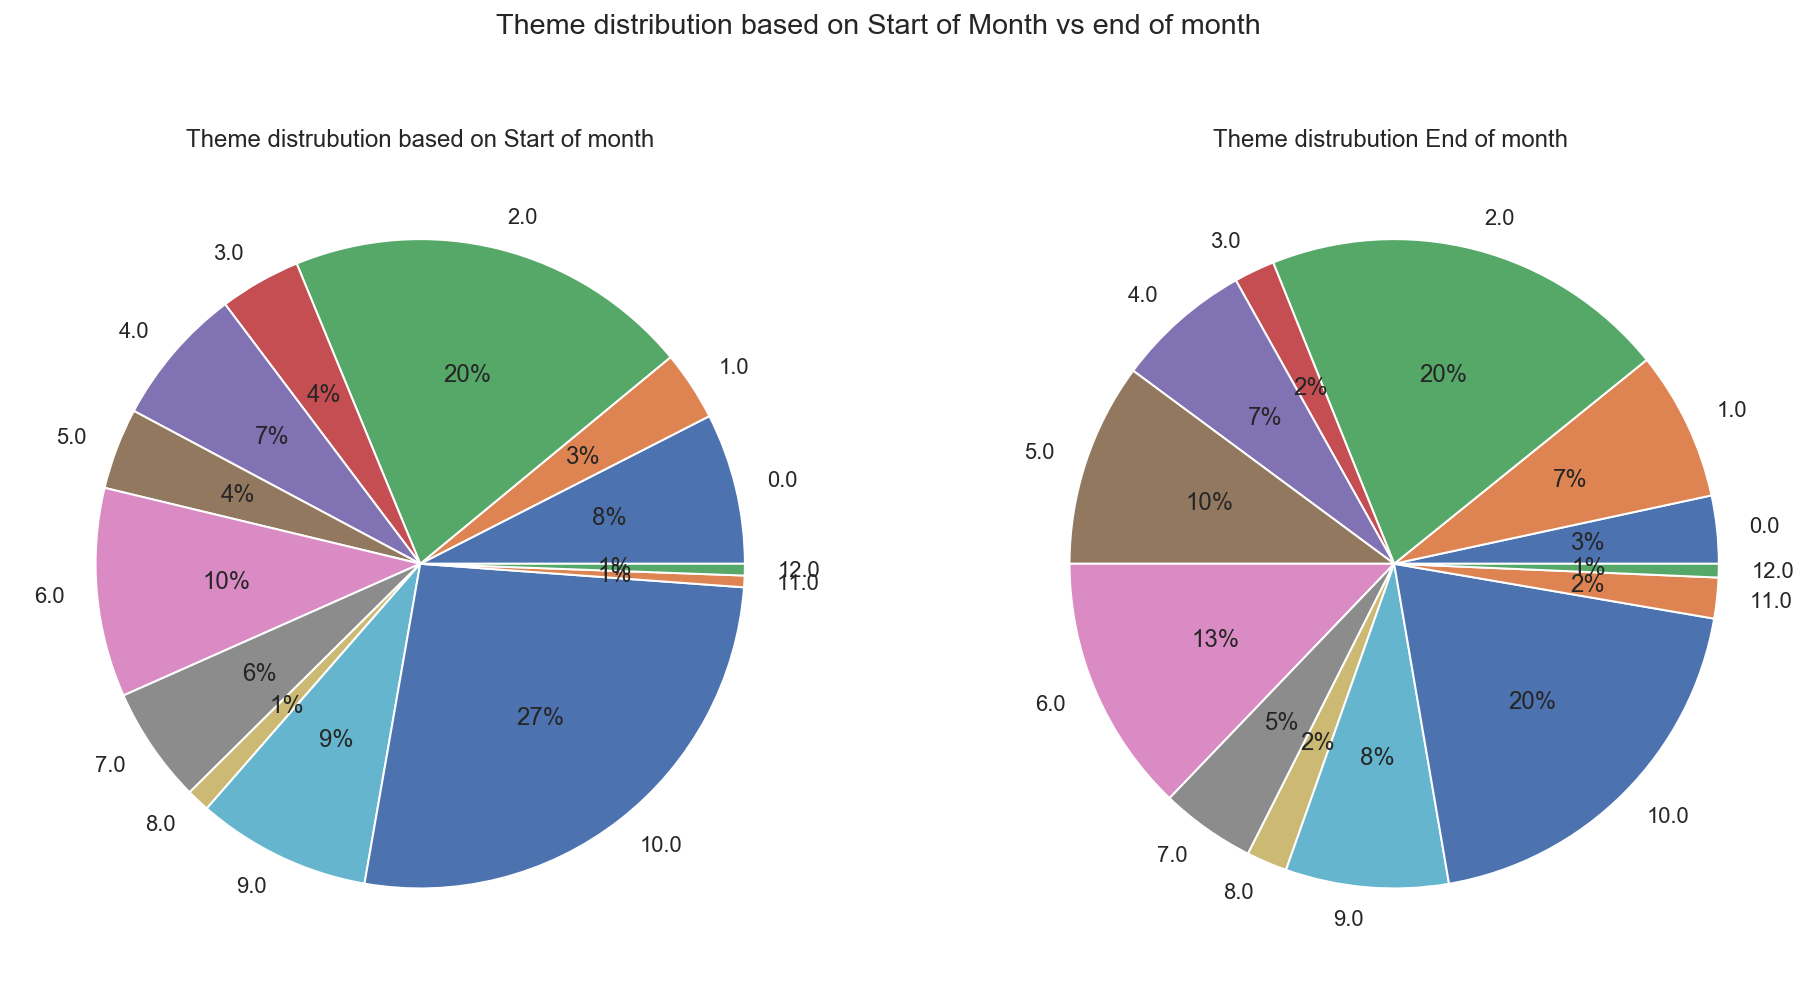

In [193]:
# Checking again after normalizing the values 
fig = plt.figure(figsize=(16,8),dpi=144)
ax1 = fig.add_subplot(121)
plt.suptitle("Theme distribution based on Start of Month vs end of month")
count = emails_df.where(emails_df["Day"].isin([1, 2, 3, 4, 5, 6])).Target.value_counts().to_frame().sort_index()
ax1.pie(count.Target, labels=count.index, autopct='%1.0f%%')
ax1.set_title("Theme distrubution based on Start of month")

# ax2 = fig.add_subplot(122)
# count = raw_df.where(df["Day"].isin([15, 16, 17, 18, 19, 20])).Target.value_counts().to_frame().sort_index()
# ax2.pie(count.Target, labels=count.index, autopct='%1.0f%%')
# ax2.set_title("Theme distrubution Middle of month ")

ax3 = fig.add_subplot(122)
count = emails_df.where(df["Day"].isin([26, 27, 28, 29, 30, 31])).Target.value_counts().to_frame().sort_index()
ax3.pie(count.Target, labels=count.index, autopct='%1.0f%%')
ax3.set_title("Theme distrubution End of month ")
plt.show()

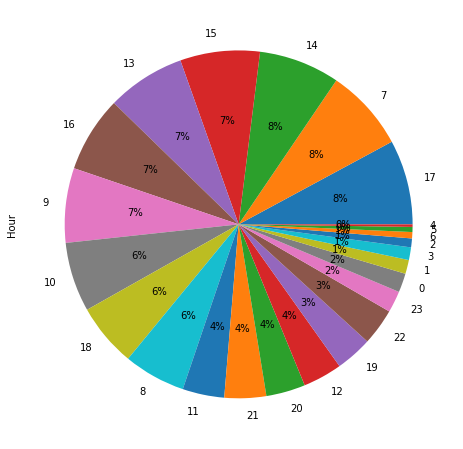

In [59]:
# Lets check the distribution of data for Year 
plt.figure(figsize=(16,8))
emails_df.Hour.value_counts().plot(kind='pie', autopct='%1.0f%%')

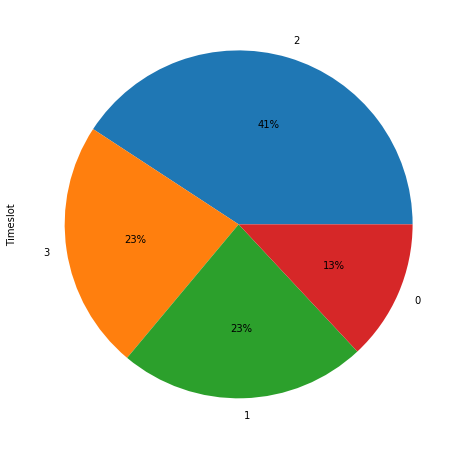

In [60]:
# Lets check the distribution of data for Timeslot 
plt.figure(figsize=(16,8))
emails_df.Timeslot.value_counts().plot(kind='pie', autopct='%1.0f%%')

### OBSERVATION : We see that maximum mails were sent during afternoon working hours, followed by morning working hours

### Lets see the word cloud for each theme

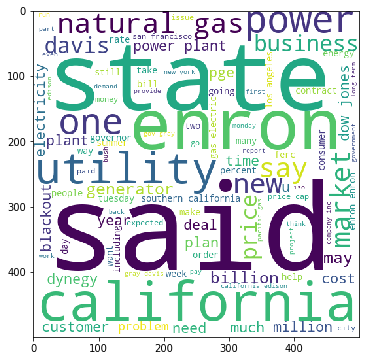

In [46]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(emails_df[emails_df['Target'] == 0]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

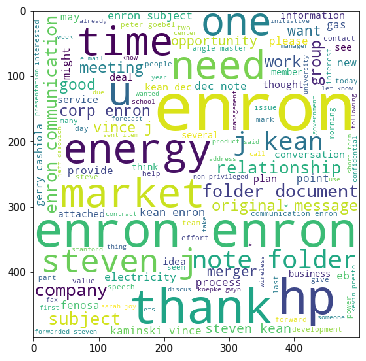

In [62]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 1]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

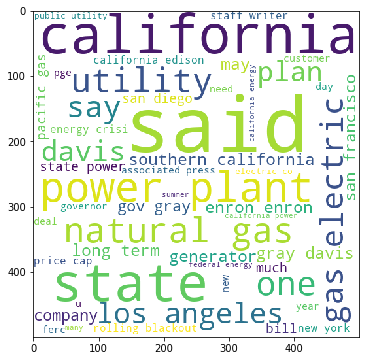

In [63]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 2]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

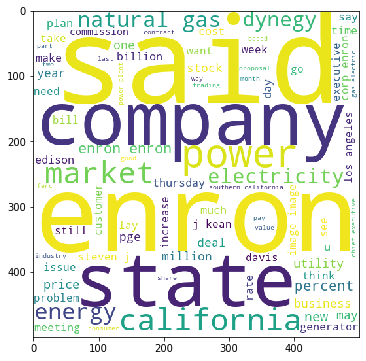

In [64]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 3]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

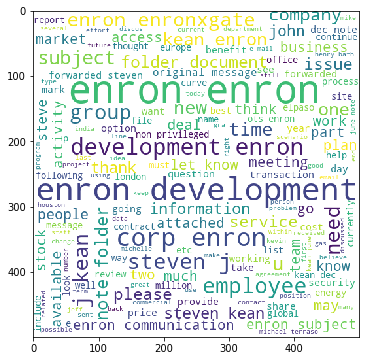

In [65]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 4]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

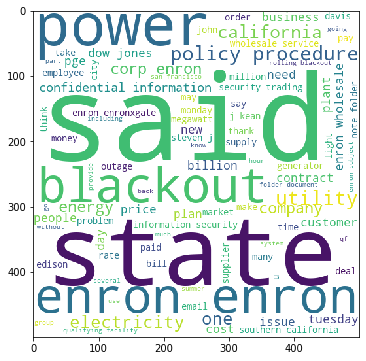

In [66]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 5]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

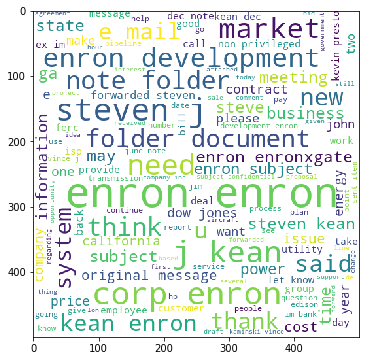

In [67]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 6]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

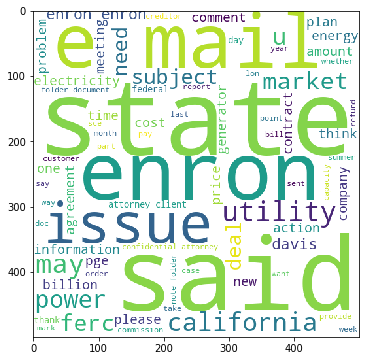

In [68]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 7]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

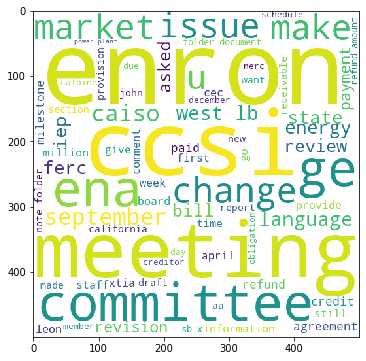

In [69]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 8]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

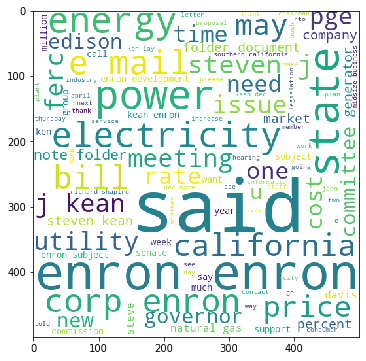

In [70]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 9]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

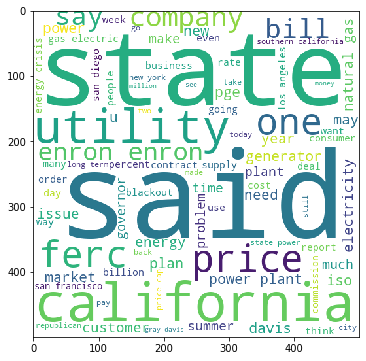

In [71]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 10]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

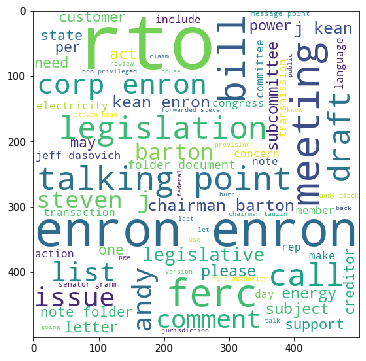

In [72]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 11]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

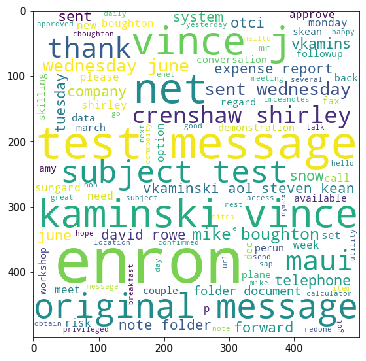

In [73]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 12]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

### We see that a lot of words are coinciding with the themes. 

## 5. Model Building first just with the Text columns

In [72]:
v = TfidfVectorizer(max_features=2000)
X = v.fit_transform(emails_df['Text'])

In [73]:
y = emails_df['Target']

In [74]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


In [75]:
email_detect_theme = MultinomialNB().fit(X_train, y_train)

In [76]:
y_pred = email_detect_theme.predict(X_test)


In [77]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='micro'))
print(f1_score(y_test,y_pred,average='micro'))

0.3508771929824561
0.3508771929824561
0.3508771929824561


### Lets see how the data performs with other models 

In [78]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='micro')
    f1 = f1_score(y_test,y_pred,average='micro')

    return accuracy, precision, f1

In [79]:
def train_all_classifier(X_train,y_train,X_test,y_test):
    svc = SVC(kernel='sigmoid', gamma=1.0)
    knc = KNeighborsClassifier()
    mnb = MultinomialNB()
    dtc = DecisionTreeClassifier(max_depth=5)
    lrc = LogisticRegression(solver='liblinear', penalty='l1')
    rfc = RandomForestClassifier(n_estimators=50, random_state=2)
    abc = AdaBoostClassifier(n_estimators=50, random_state=2)
    etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
    gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
    xgb = XGBClassifier(n_estimators=50,random_state=2)
    clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
            }
    algo_name = []
    accuracy_scores = []
    precision_scores = []
    f1_scores = []

    for name,clf in clfs.items():

        current_accuracy, current_precision, current_f1  = train_classifier(clf, X_train,y_train,X_test,y_test)

        print("For ",name)
        print("Accuracy - ",current_accuracy)
        print("Precision - ",current_precision)
        print("F1_scores - ",current_f1)

        accuracy_scores.append(current_accuracy)
        precision_scores.append(current_precision)
        f1_scores.append(current_f1)
        algo_name.append(name)
        
          
    performance_df = pd.DataFrame.from_dict({'Algorithm':algo_name, 'Accuracy':accuracy_scores, 'Precision':precision_scores, 'F1': f1_scores}).sort_values('F1',ascending=False)
      
        
    return performance_df

In [80]:
train_all_classifier(X_train,y_train,X_test,y_test)

For  SVC
Accuracy -  0.43859649122807015
Precision -  0.43859649122807015
F1_scores -  0.43859649122807015
For  KN
Accuracy -  0.38596491228070173
Precision -  0.38596491228070173
F1_scores -  0.38596491228070173
For  NB
Accuracy -  0.3508771929824561
Precision -  0.3508771929824561
F1_scores -  0.3508771929824561
For  DT
Accuracy -  0.26900584795321636
Precision -  0.26900584795321636
F1_scores -  0.26900584795321636
For  LR
Accuracy -  0.38011695906432746
Precision -  0.38011695906432746
F1_scores -  0.38011695906432746
For  RF
Accuracy -  0.30994152046783624
Precision -  0.30994152046783624
F1_scores -  0.30994152046783624
For  AdaBoost
Accuracy -  0.23976608187134502
Precision -  0.23976608187134502
F1_scores -  0.23976608187134502
For  ETC
Accuracy -  0.3742690058479532
Precision -  0.3742690058479532
F1_scores -  0.37426900584795314
For  GBDT
Accuracy -  0.36257309941520466
Precision -  0.36257309941520466
F1_scores -  0.3625730994152046
[20:23:01] WARNING: C:/Users/Administrator

C:\Users\PRINCY\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For  xgb
Accuracy -  0.3216374269005848
Precision -  0.3216374269005848
F1_scores -  0.3216374269005848


,Algorithm,Accuracy,Precision,F1
0,SVC,0.438596,0.438596,0.438596
1,KN,0.385965,0.385965,0.385965
4,LR,0.380117,0.380117,0.380117
7,ETC,0.374269,0.374269,0.374269
8,GBDT,0.362573,0.362573,0.362573
2,NB,0.350877,0.350877,0.350877
9,xgb,0.321637,0.321637,0.321637
5,RF,0.309942,0.309942,0.309942
3,DT,0.269006,0.269006,0.269006
6,AdaBoost,0.239766,0.239766,0.239766


### Lets try to improve the model 

#### Balancing the data

In [80]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=4)

# fit predictor and target variable
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 5

### We see that the theme with the least data has only 4 samples which is too less . We have to add more data 